<a href="https://colab.research.google.com/github/junseo0im/mimic/blob/main/mimic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sqlite3
import pandas as pd

# DB 연결
conn = sqlite3.connect("/content/drive/MyDrive/Data/MIMIC4-hosp-icu.db")

# 전체 테이블 목록 확인
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)


                  name
0           admissions
1        diagnoses_icd
2             drgcodes
3              d_hcpcs
4      d_icd_diagnoses
5     d_icd_procedures
6           d_labitems
7                 emar
8          emar_detail
9          hcpcsevents
10           labevents
11  microbiologyevents
12                 omr
13            patients
14            pharmacy
15                 poe
16          poe_detail
17       prescriptions
18      procedures_icd
19            provider
20            services
21           transfers
22           caregiver
23         chartevents
24      datetimeevents
25             d_items
26            icustays
27    ingredientevents
28         inputevents
29        outputevents
30     procedureevents


In [4]:
cohort_sql = """
WITH sepsis_hadm AS (
  SELECT DISTINCT d.hadm_id
  FROM diagnoses_icd d
  WHERE d.icd_code LIKE 'A40%'
     OR d.icd_code LIKE 'A41%'
     OR d.icd_code LIKE 'R65%'
     OR d.icd_code LIKE 'R57.2%'
)
SELECT
  a.hadm_id,
  a.subject_id,
  a.admittime,
  a.dischtime,
  a.deathtime,
  CASE WHEN a.deathtime IS NULL THEN 0 ELSE 1 END AS death,
  p.gender,
  p.anchor_age
FROM admissions a
JOIN patients p ON a.subject_id = p.subject_id
JOIN sepsis_hadm s ON a.hadm_id = s.hadm_id
"""

cohort = pd.read_sql(cohort_sql, conn)
cohort

hadm_id  subject_id            admittime            dischtime  \
0      27012892    10001401  2133-07-09 22:22:00  2133-07-13 18:43:00   
1      27060146    10001401  2131-10-01 01:33:00  2131-10-05 15:45:00   
2      26133978    10001843  2134-12-05 00:10:00  2134-12-06 12:54:00   
3      25442395    10002013  2166-04-06 18:47:00  2166-04-19 16:38:00   
4      23559586    10003400  2137-08-04 00:07:00  2137-09-02 17:05:00   
...         ...         ...                  ...                  ...   
13999  27219994    19992507  2178-10-30 18:44:00  2178-11-06 02:29:00   
14000  28374158    19994020  2132-09-06 18:28:00  2132-09-29 18:00:00   
14001  26871572    19995258  2130-06-07 21:35:00  2130-06-15 14:45:00   
14002  24325646    19996091  2186-06-07 22:30:00  2186-06-10 20:32:00   
14003  20793010    19997886  2186-11-12 07:10:00  2186-12-10 20:35:00   

                 deathtime  death gender  anchor_age  
0                     None      0      F          89  
1                     None      0      F          89  
2      2134-12-06 12:54:00      1      M          73  
3                     None      0      F          53  
4      2137-09-02 17:05:00      1      F          72  
...                    ...    ...    ...         ...  
13999  2178-11-06 02:29:00      1      F          61  
14000                 None      0      M          91  
14001                 None      0      F          57  
14002                 None      0      F          67  
14003                 None      0      M          67  

[14004 rows x 8 columns]

In [5]:
like_clause = """
LOWER(pr.drug) LIKE '%penem%'
OR LOWER(pr.drug) LIKE '%cillin%'
OR LOWER(pr.drug) LIKE '%cef%'
OR LOWER(pr.drug) LIKE '%ceph%'
OR LOWER(pr.drug) LIKE '%vanco%'
OR LOWER(pr.drug) LIKE '%mycin%'
OR LOWER(pr.drug) LIKE '%floxacin%'
OR LOWER(pr.drug) LIKE '%metronidazole%'
OR LOWER(pr.drug) LIKE '%linezolid%'
OR LOWER(pr.drug) LIKE '%daptomycin%'
OR LOWER(pr.drug) LIKE '%tigecycline%'
OR LOWER(pr.drug) LIKE '%aztreonam%'
OR LOWER(pr.drug) LIKE '%colistin%'
"""



abx_sql = f"""
WITH sepsis_hadm AS (
  SELECT DISTINCT d.hadm_id
  FROM diagnoses_icd d
  WHERE d.icd_code LIKE 'A40%'
     OR d.icd_code LIKE 'A41%'
     OR d.icd_code LIKE 'R65%'
     OR d.icd_code LIKE 'R57.2%'
),
cohort AS (
  SELECT
    a.hadm_id,
    a.subject_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    CASE WHEN a.deathtime IS NULL THEN 0 ELSE 1 END AS death,
    p.gender,
    p.anchor_age
  FROM admissions a
  JOIN patients p ON a.subject_id = p.subject_id
  JOIN sepsis_hadm s ON a.hadm_id = s.hadm_id
)
SELECT
  pr.subject_id,
  pr.hadm_id,
  DATETIME(pr.starttime) AS starttime,
  DATETIME(pr.stoptime)  AS stoptime,
  LOWER(pr.drug)         AS drug
FROM prescriptions pr
JOIN cohort c ON c.hadm_id = pr.hadm_id
WHERE ({like_clause})
"""


abx = pd.read_sql(abx_sql, conn)


print("총 행 수:", len(abx))
abx.head()

총 행 수: 135776


subject_id   hadm_id            starttime             stoptime  \
0    10001401  27012892  2133-07-09 23:00:00  2133-07-09 23:00:00   
1    10001401  27012892  2133-07-13 10:00:00  2133-07-13 23:00:00   
2    10001401  27012892  2133-07-10 01:00:00  2133-07-10 08:00:00   
3    10001401  27012892  2133-07-10 09:00:00  2133-07-10 11:00:00   
4    10001401  27012892  2133-07-10 16:00:00  2133-07-13 09:00:00   

                drug  
0  ampicillin sodium  
1  ampicillin sodium  
2        ceftazidime  
3        ceftazidime  
4        ceftriaxone

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

# datetime 변환
cohort['admittime'] = pd.to_datetime(cohort['admittime'])
cohort['dischtime'] = pd.to_datetime(cohort['dischtime'])
abx['starttime'] = pd.to_datetime(abx['starttime'])
abx['stoptime'] = pd.to_datetime(abx['stoptime'])

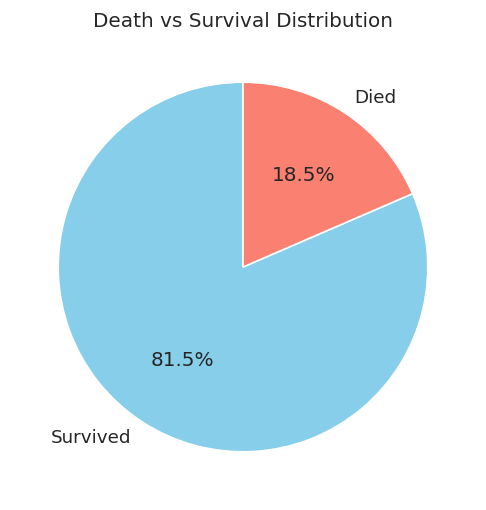

In [7]:
plt.figure(figsize=(5,5))
plt.pie(
    cohort['death'].value_counts(),
    labels=['Survived','Died'],
    autopct='%1.1f%%',
    colors=['skyblue','salmon'],
    startangle=90
)
plt.title('Death vs Survival Distribution')
plt.show()

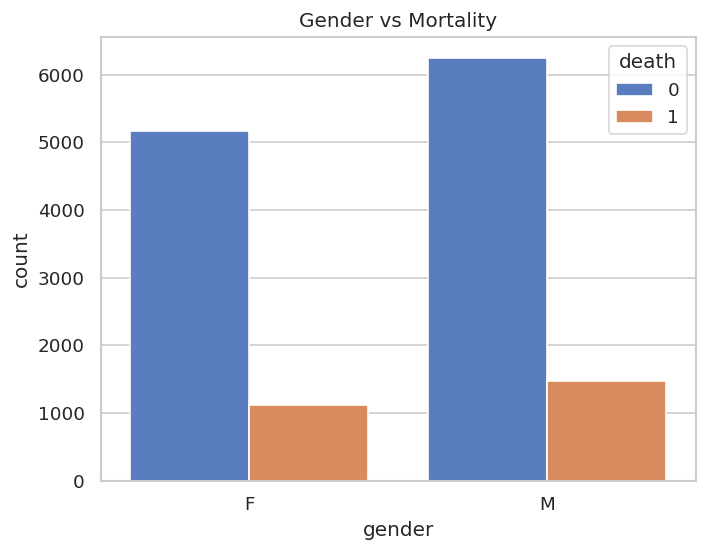

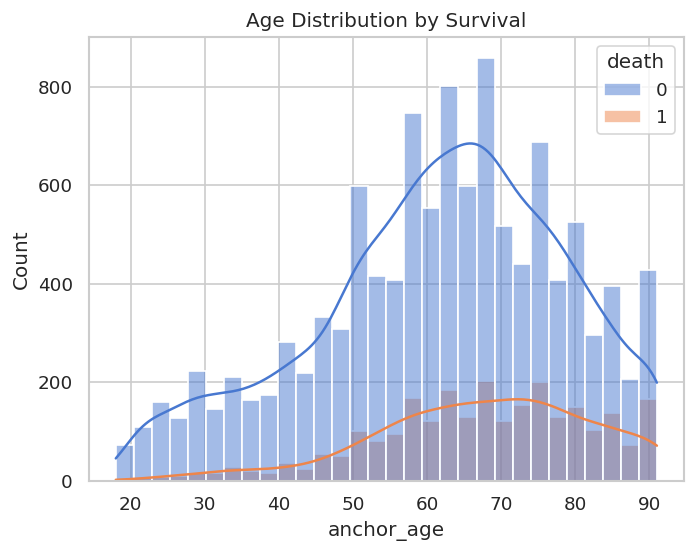

/tmp/ipython-input-2570906390.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_death = cohort.groupby('age_bin')['death'].mean().reset_index()


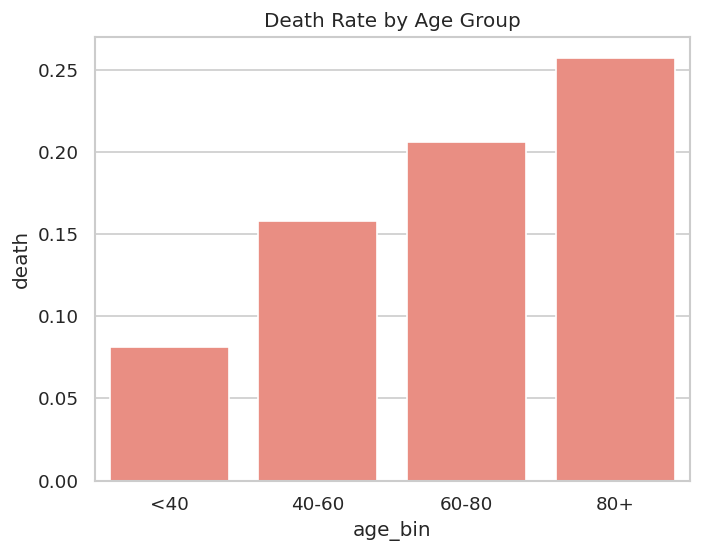

In [8]:
# 성별별 사망률
sns.countplot(data=cohort, x='gender', hue='death')
plt.title('Gender vs Mortality')
plt.show()

# 나이 분포
sns.histplot(data=cohort, x='anchor_age', hue='death', kde=True, bins=30)
plt.title('Age Distribution by Survival')
plt.show()

# 연령대별 사망률
cohort['age_bin'] = pd.cut(cohort['anchor_age'], bins=[0,40,60,80,100], labels=['<40','40-60','60-80','80+'])
age_death = cohort.groupby('age_bin')['death'].mean().reset_index()
sns.barplot(data=age_death, x='age_bin', y='death', color='salmon')
plt.title('Death Rate by Age Group')
plt.show()

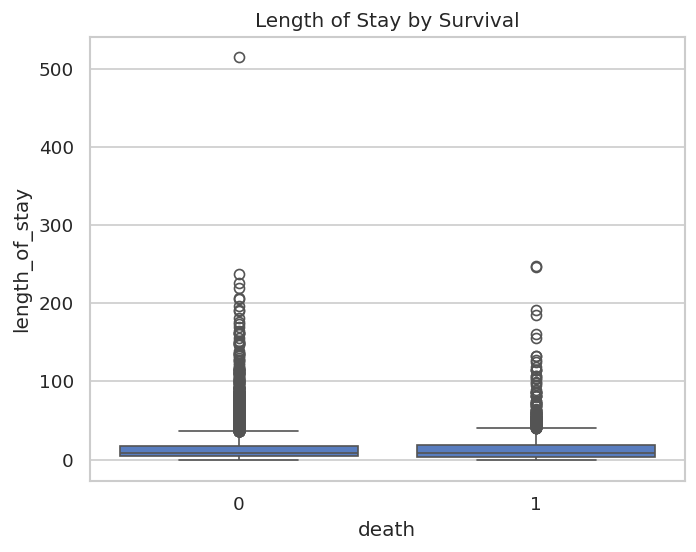

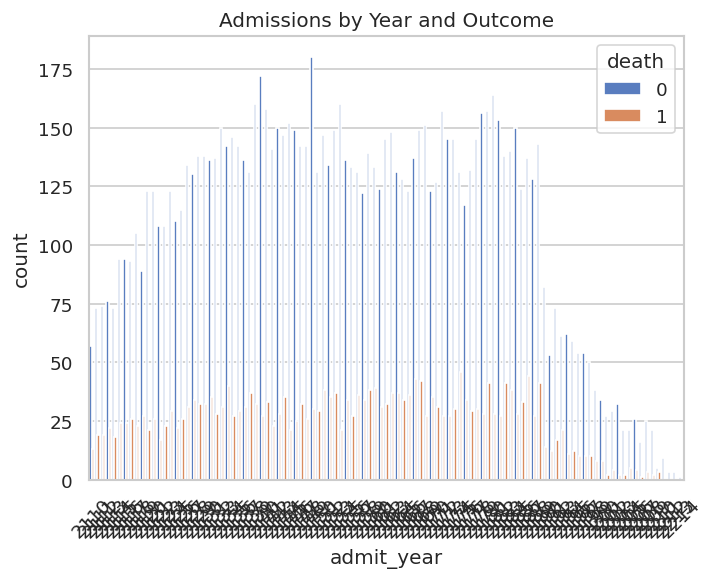

In [9]:
# 체류기간
cohort['length_of_stay'] = (cohort['dischtime'] - cohort['admittime']).dt.days

sns.boxplot(data=cohort, x='death', y='length_of_stay')
plt.title('Length of Stay by Survival')
plt.show()

# 입원일자 분포
cohort['admit_year'] = cohort['admittime'].dt.year
sns.countplot(data=cohort, x='admit_year', hue='death')
plt.title('Admissions by Year and Outcome')
plt.xticks(rotation=45)
plt.show()

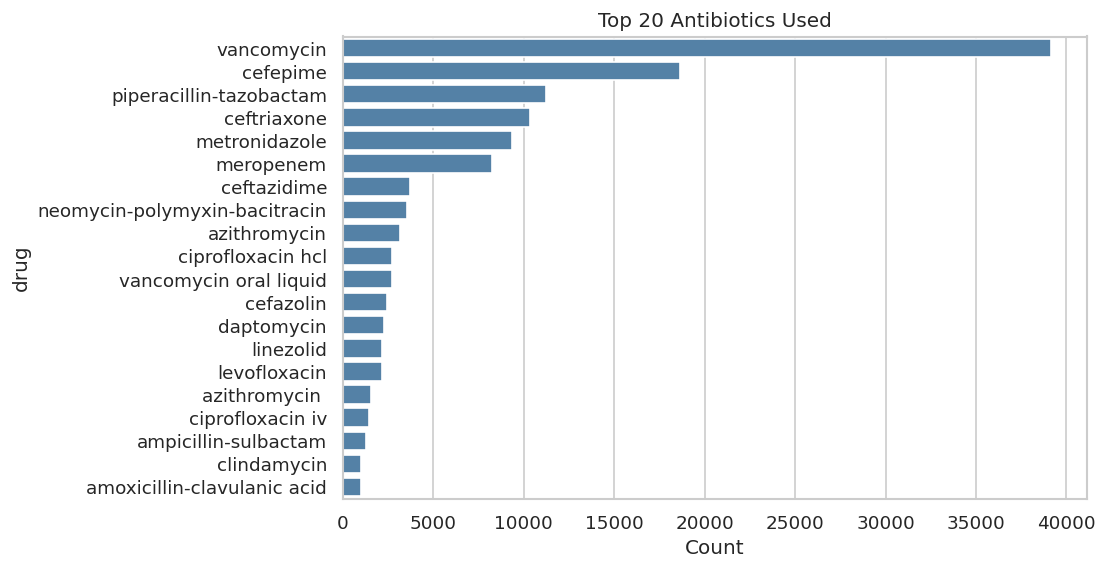

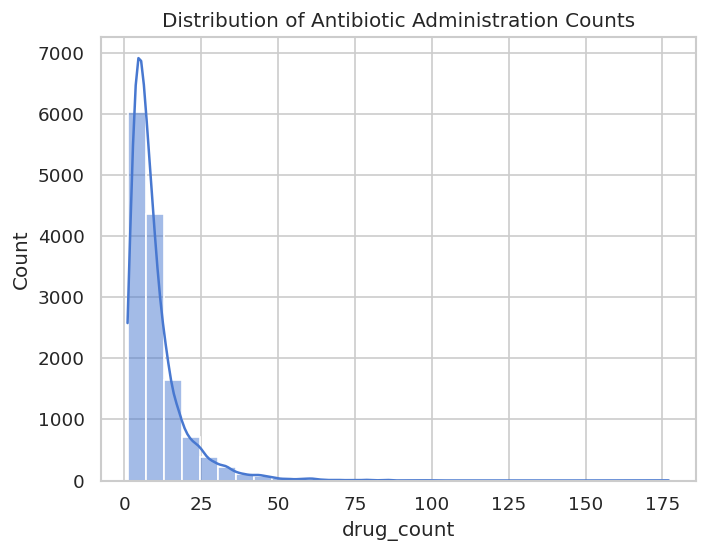

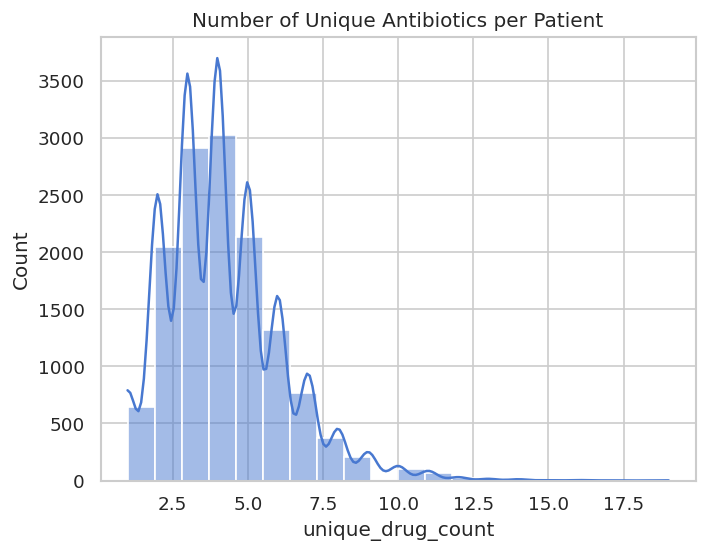

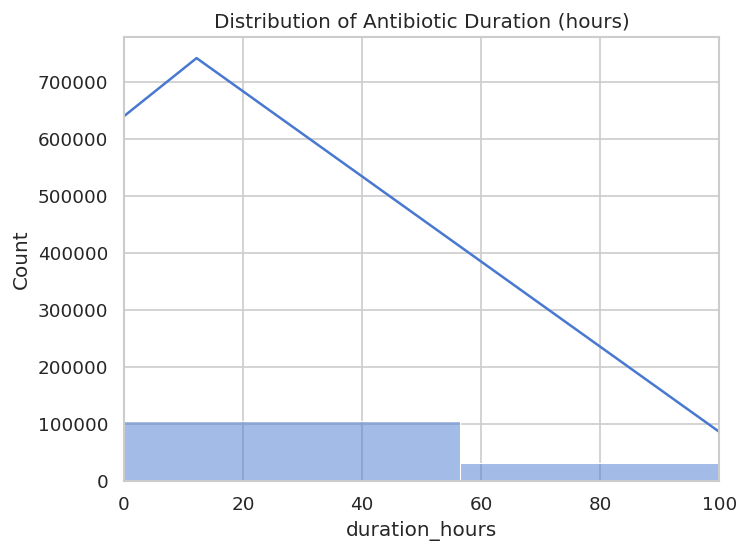

In [10]:
# 상위 항생제
top_drugs = abx['drug'].value_counts().head(20)
plt.figure(figsize=(8,5))
sns.barplot(y=top_drugs.index, x=top_drugs.values, color='steelblue')
plt.title('Top 20 Antibiotics Used')
plt.xlabel('Count')
plt.show()

# 환자당 투여 횟수
drug_count = abx.groupby('hadm_id')['drug'].count().reset_index(name='drug_count')
sns.histplot(drug_count['drug_count'], bins=30, kde=True)
plt.title('Distribution of Antibiotic Administration Counts')
plt.show()

# 고유 항생제 수
unique_drugs = abx.groupby('hadm_id')['drug'].nunique().reset_index(name='unique_drug_count')
sns.histplot(unique_drugs['unique_drug_count'], bins=20, kde=True)
plt.title('Number of Unique Antibiotics per Patient')
plt.show()

# 투여 지속시간
abx['duration_hours'] = (abx['stoptime'] - abx['starttime']).dt.total_seconds() / 3600
sns.histplot(abx['duration_hours'], bins=50, kde=True)
plt.xlim(0, 100)
plt.title('Distribution of Antibiotic Duration (hours)')
plt.show()

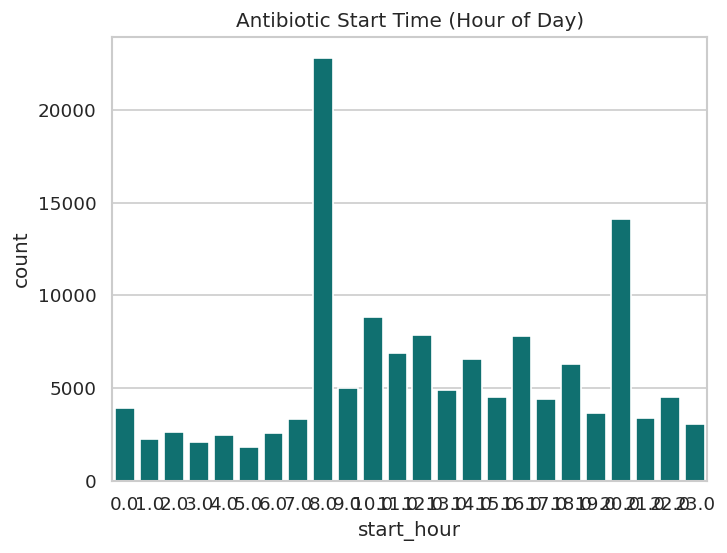

/tmp/ipython-input-2622953890.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(abx_sorted['interval_hours'].dropna(), shade=True)


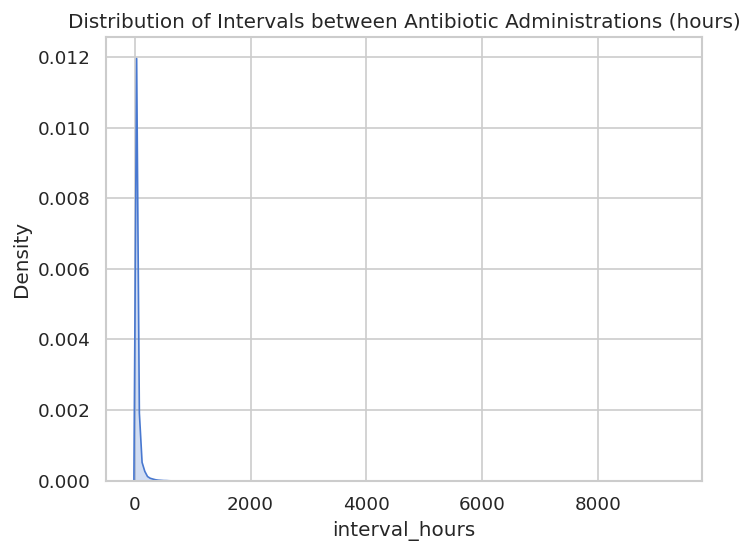

In [11]:
# 투여 시작 시각 (시간대별)
abx['start_hour'] = abx['starttime'].dt.hour
sns.countplot(data=abx, x='start_hour', color='teal')
plt.title('Antibiotic Start Time (Hour of Day)')
plt.show()

# 투여 간격
abx_sorted = abx.sort_values(['hadm_id', 'starttime'])
abx_sorted['interval_hours'] = abx_sorted.groupby('hadm_id')['starttime'].diff().dt.total_seconds()/3600
sns.kdeplot(abx_sorted['interval_hours'].dropna(), shade=True)
plt.title('Distribution of Intervals between Antibiotic Administrations (hours)')
plt.show()

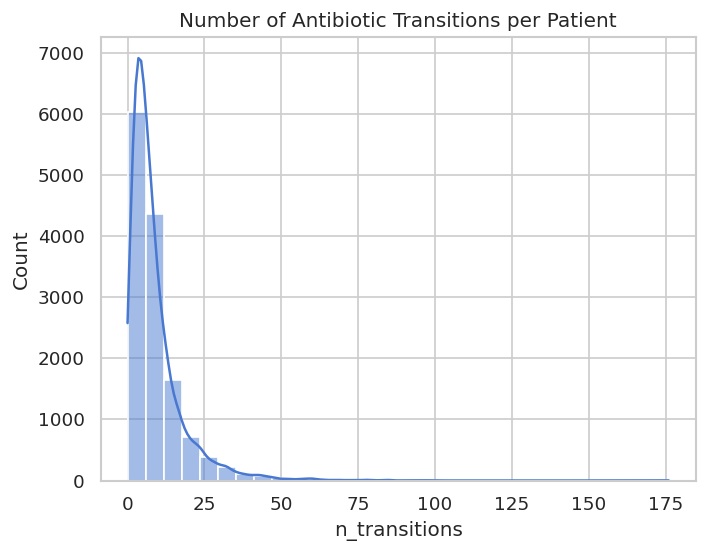

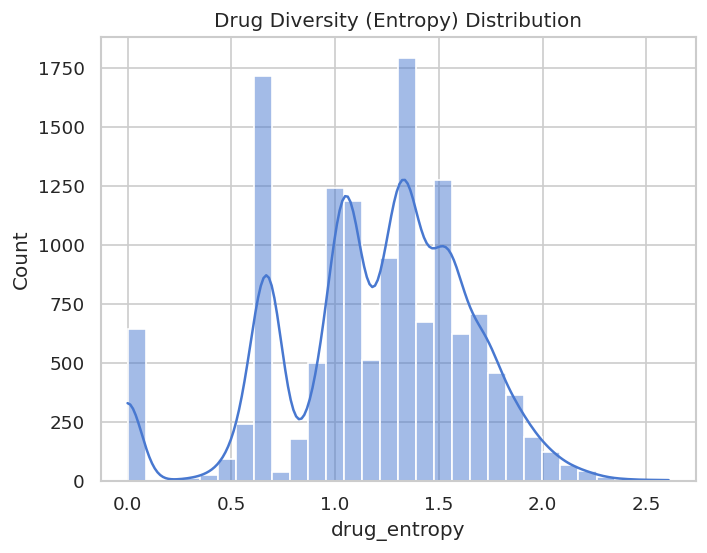

In [12]:
from itertools import pairwise
from scipy.stats import entropy

# 환자별 전환 수
def count_transitions(x):
    return len(list(pairwise(x.sort_values().values)))

transitions = abx.groupby('hadm_id')['drug'].apply(count_transitions).reset_index(name='n_transitions')

# 엔트로피 (항생제 다양성 지표)
entropy_values = abx.groupby('hadm_id')['drug'].apply(lambda x: entropy(pd.Series(x).value_counts()))
entropy_values = entropy_values.reset_index(name='drug_entropy')

# 분포 시각화
sns.histplot(transitions['n_transitions'], bins=30, kde=True)
plt.title('Number of Antibiotic Transitions per Patient')
plt.show()

sns.histplot(entropy_values['drug_entropy'], bins=30, kde=True)
plt.title('Drug Diversity (Entropy) Distribution')
plt.show()

In [13]:
abx['drug'].value_counts().head(50)

drug
vancomycin                                         39169
cefepime                                           18629
piperacillin-tazobactam                            11249
ceftriaxone                                        10362
metronidazole                                       9328
meropenem                                           8219
ceftazidime                                         3724
neomycin-polymyxin-bacitracin                       3520
azithromycin                                        3184
ciprofloxacin hcl                                   2743
vancomycin oral liquid                              2741
cefazolin                                           2466
daptomycin                                          2296
linezolid                                           2170
levofloxacin                                        2157
azithromycin                                        1529
ciprofloxacin iv                                    1457
ampicillin-sulbactam                                1294
clindamycin                                          992
amoxicillin-clavulanic acid                          986
tobramycin sulfate                                   736
ampicillin sodium                                    721
metronidazole (flagyl)                               627
cefpodoxime proxetil                                 590
ertapenem sodium                                     501
nafcillin                                            407
erythromycin 0.5% ophth oint                         351
vancomycin antibiotic lock                           308
aztreonam                                            279
vancomycin – pharmacy to dose (id consult only)      264
cephalexin                                           255
ceftaroline                                          230
vancomycin enema                                     204
ceftazidime-avibactam (avycaz)                       133
erythromycin                                         126
ciprofloxacin 0.3% ophth soln                        126
amoxicillin                                          125
ceftolozane-tazobactam                               117
ampicillin desensitization                           108
tobramycin - dosing by pharmacy                       81
tigecycline                                           79
penicillin g potassium                                73
nafcillin desensitization                             73
meropenem desensitization                             69
ceftriaxone desensitization                           66
amoxicillin-clavulanate susp.                         65
neomycin sulfate                                      55
cefepime desensitization                              48
tobramycin inhalation soln                            46
fosfomycin tromethamine                               41
Name: count, dtype: int64

In [14]:
pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.9 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=e5e5afc5ae64fdcf35e392552fc4667eb1090695610033fb65f589eee0331470
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built intervaltree


In [25]:
# 첫 항생제 시각
first_abx = (abx[['hadm_id','starttime']]
             .dropna()
             .groupby('hadm_id')['starttime'].min()
             .reset_index()
             .rename(columns={'hadm_id':'case_id','starttime':'first_abx_time'}))
abx_delay = cohort[['hadm_id','admittime','death']].rename(columns={'hadm_id':'case_id'})
abx_delay = abx_delay.merge(first_abx, on='case_id', how='left')
abx_delay['abx_delay_hours'] = (abx_delay['first_abx_time'] - abx_delay['admittime']).dt.total_seconds()/3600

# 준수 플래그 (예: 3시간/6시간 이내)
abx_delay['abx_within_3h'] = (abx_delay['abx_delay_hours']<=3).astype('int8')
abx_delay['abx_within_6h'] = (abx_delay['abx_delay_hours']<=6).astype('int8')

abx_delay[['case_id','abx_delay_hours','abx_within_3h','abx_within_6h','death']].head(30)

case_id  abx_delay_hours  abx_within_3h  abx_within_6h  death
0   27012892         0.633333              1              1      0
1   27060146         2.450000              1              1      0
2   26133978        19.833333              0              0      1
3   25442395         4.216667              0              1      0
4   23559586       160.883333              0              0      1
5   28317408        68.150000              0              0      1
6   27104518         4.566667              0              1      0
7   27229065              NaN              0              0      0
8   26194826        26.150000              0              0      0
9   24348100         4.650000              0              1      0
10  22987108       255.383333              0              0      1
11  25501245         8.983333              0              0      0
12  27998273         4.700000              0              1      0
13  21312888        12.233333              0              0      0
14  20162667       -20.316667              1              1      0
15  26712576         2.850000              1              1      1
16  20219031        13.050000              0              0      0
17  22216667        83.933333              0              0      0
18  29968861         5.100000              0              1      0
19  23798746              NaN              0              0      0
20  29778485        54.483333              0              0      0
21  28958296        17.116667              0              0      0
22  20579647         3.383333              0              1      0
23  23586319        12.083333              0              0      1
24  22068925        13.633333              0              0      0
25  22413744         4.083333              0              1      0
26  24698912         8.300000              0              0      0
27  25103777         5.916667              0              1      0
28  27525946        25.883333              0              0      0
29  29279905         4.583333              0              1      0

In [16]:
event_log = abx.merge(cohort[['hadm_id', 'death']], on='hadm_id', how='left')

In [17]:
event_log = event_log[['hadm_id', 'starttime', 'drug', 'death']]
event_log.rename(columns={'hadm_id': 'case_id', 'drug': 'activity', 'starttime': 'timestamp'}, inplace=True)

In [18]:
print(event_log.columns)
print(event_log.dtypes)
print(event_log.head())

Index(['case_id', 'timestamp', 'activity', 'death'], dtype='object')
case_id               int64
timestamp    datetime64[ns]
activity             object
death                 int64
dtype: object
    case_id           timestamp           activity  death
0  27012892 2133-07-09 23:00:00  ampicillin sodium      0
1  27012892 2133-07-13 10:00:00  ampicillin sodium      0
2  27012892 2133-07-10 01:00:00        ceftazidime      0
3  27012892 2133-07-10 09:00:00        ceftazidime      0
4  27012892 2133-07-10 16:00:00        ceftriaxone      0


In [19]:
event_log['timestamp'] = pd.to_datetime(
    event_log['timestamp'], errors='coerce', utc=True
)

# 변환 확인
print(event_log.dtypes)


case_id                    int64
timestamp    datetime64[ns, UTC]
activity                  object
death                      int64
dtype: object


In [20]:
event_log = event_log.dropna(subset=['timestamp']).copy()
event_log = event_log.sort_values(['case_id', 'timestamp']).reset_index(drop=True)

In [21]:
# 1) timestamp를 진짜 datetime으로
event_log['timestamp'] = pd.to_datetime(event_log['timestamp'], errors='coerce', utc=True)
event_log = event_log.dropna(subset=['timestamp']).copy()

event_log['timestamp'] = event_log['timestamp'].dt.tz_localize(None)

event_log['case_id']  = event_log['case_id'].astype(str)
event_log['activity'] = event_log['activity'].astype(str)

# 3) 시간순 정렬
event_log = event_log.sort_values(['case_id','timestamp']).reset_index(drop=True)


In [22]:
print(event_log.dtypes)
# 기대: case_id=object, activity=object, timestamp=datetime64[ns], death=int64

case_id              object
timestamp    datetime64[ns]
activity             object
death                 int64
dtype: object


In [23]:
from pm4py.algo.discovery.dfg import algorithm as dfg_algo

params = {
    dfg_algo.Parameters.CASE_ID_KEY: 'case_id',
    dfg_algo.Parameters.ACTIVITY_KEY: 'activity',
    dfg_algo.Parameters.TIMESTAMP_KEY: 'timestamp',
}

# 빈도 기반 DFG
dfg = dfg_algo.apply(event_log, parameters=params, variant=dfg_algo.Variants.FREQUENCY)

# (선택) 성능 기반 DFG (간선에 평균 소요시간)
dfg_perf = dfg_algo.apply(event_log, parameters=params, variant=dfg_algo.Variants.PERFORMANCE)

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


전체 Top-N DFG 생성 중...


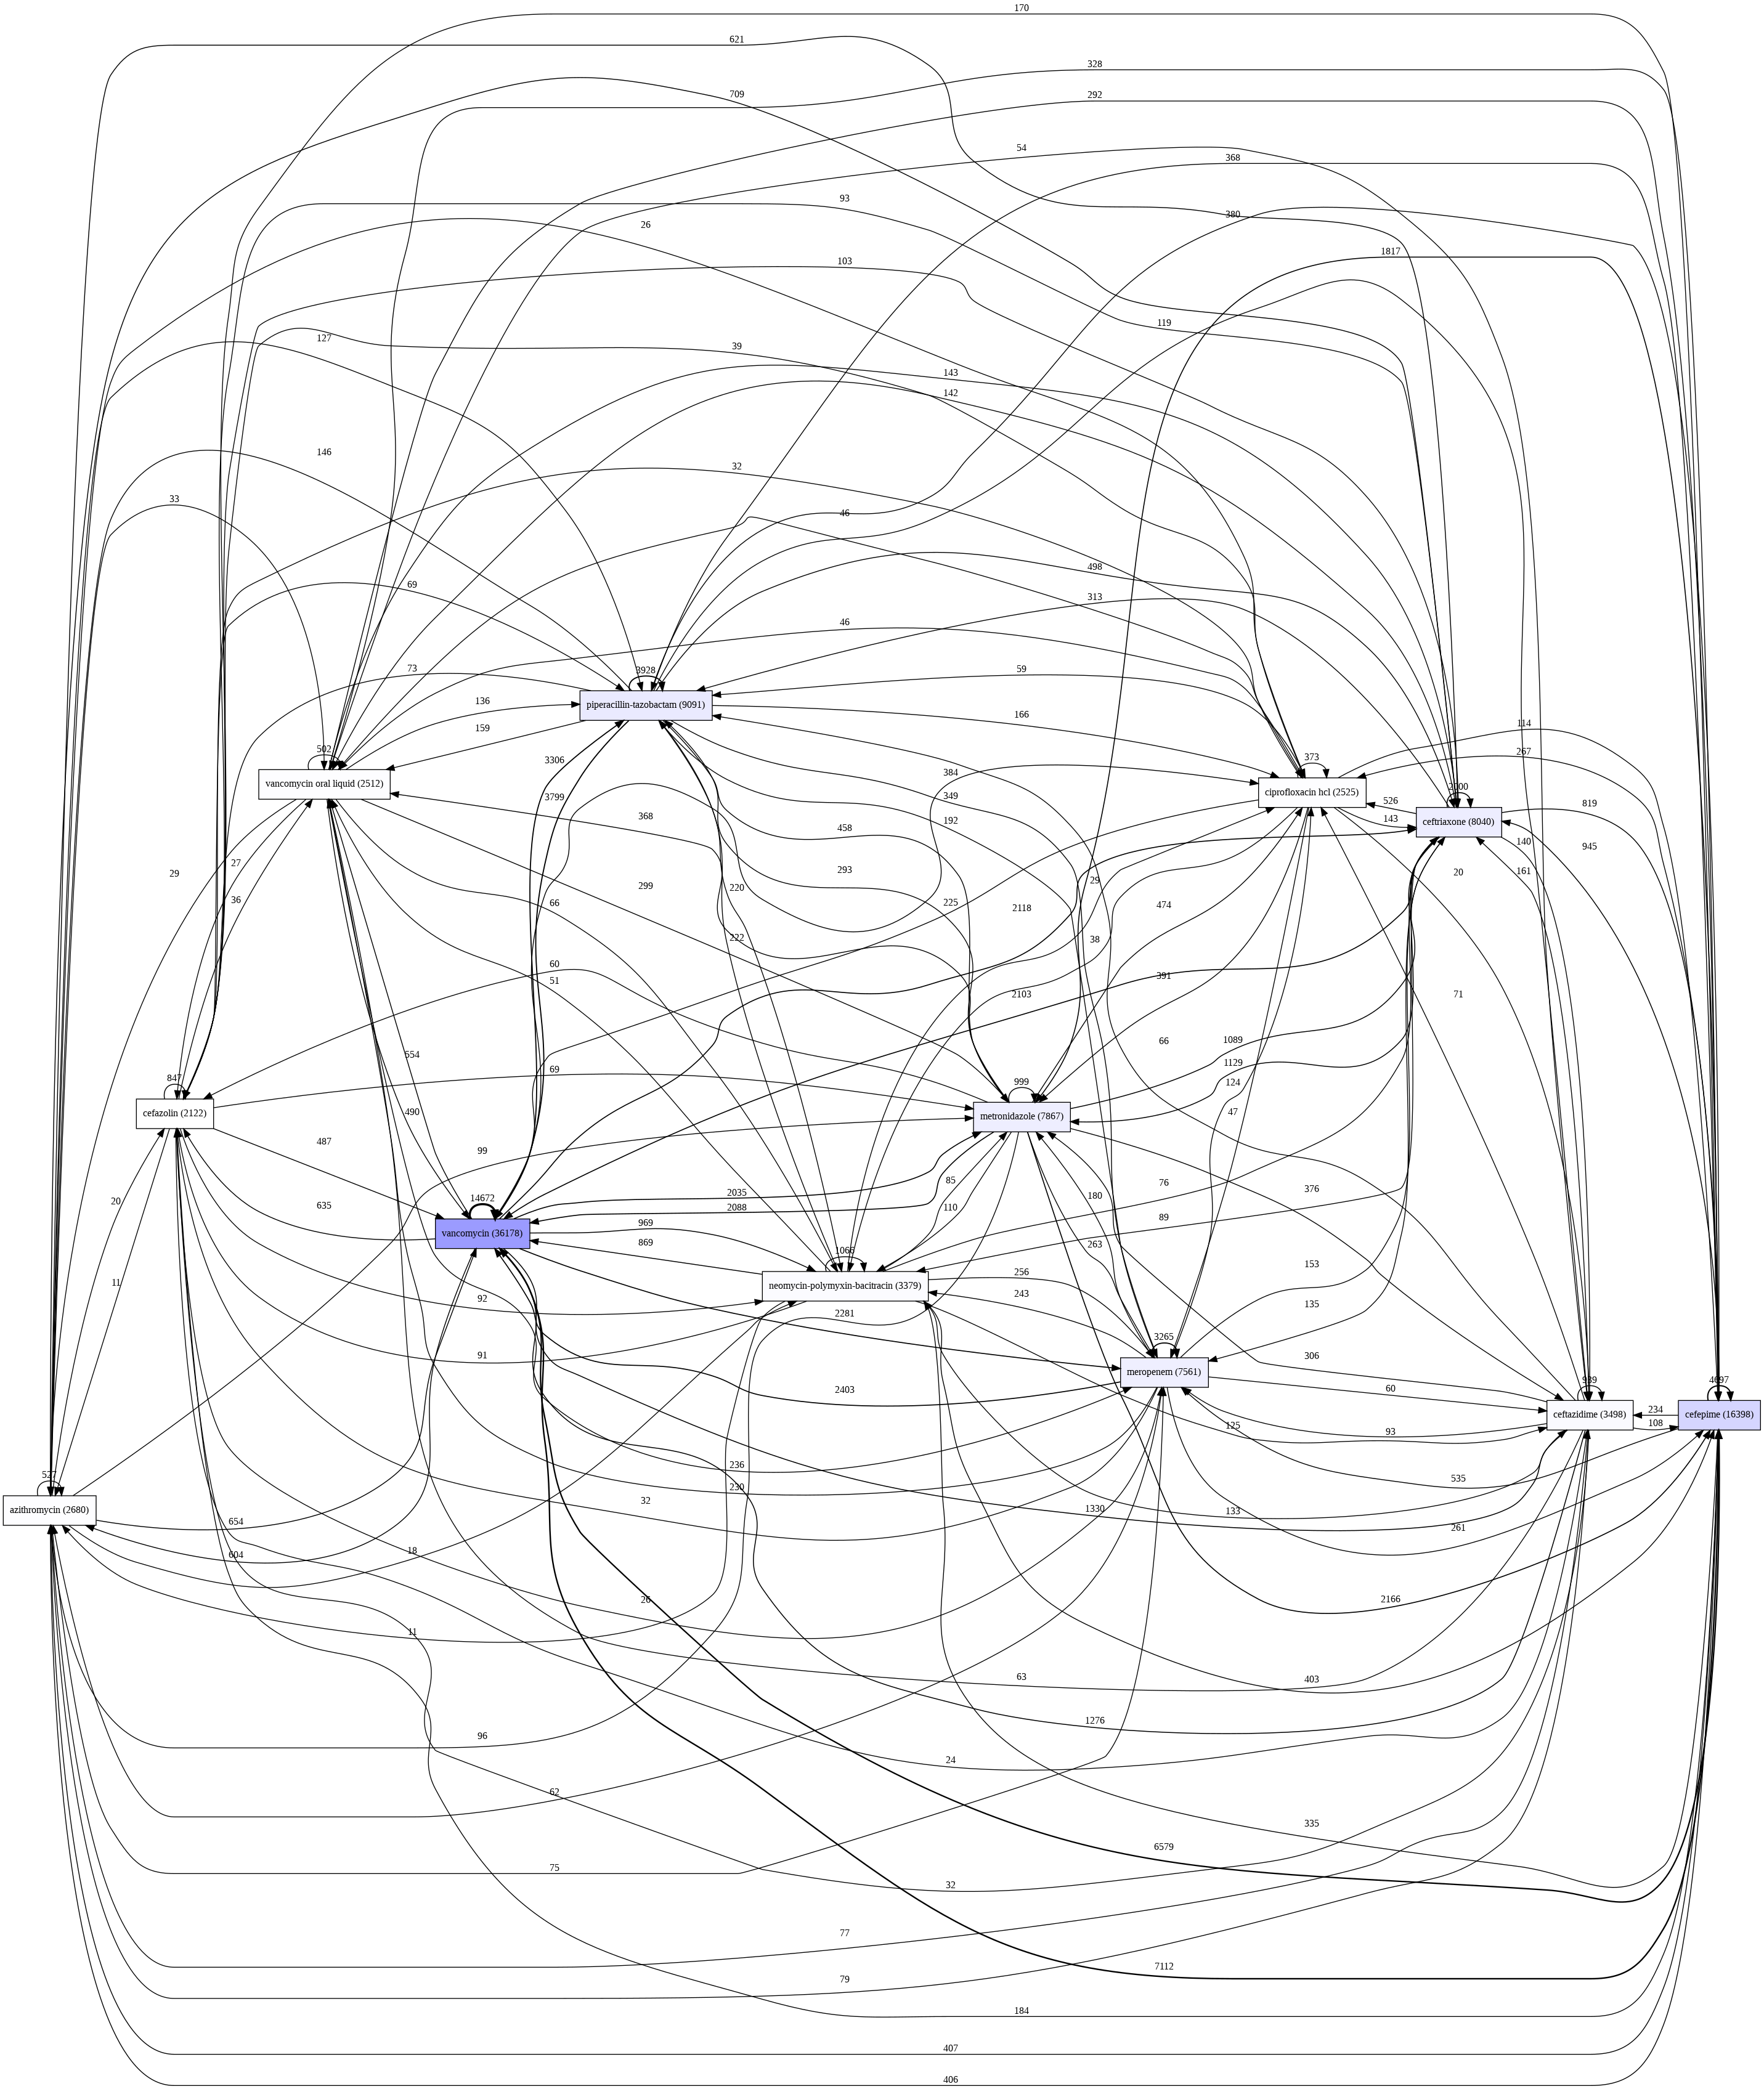

생존 환자 DFG 생성 중...


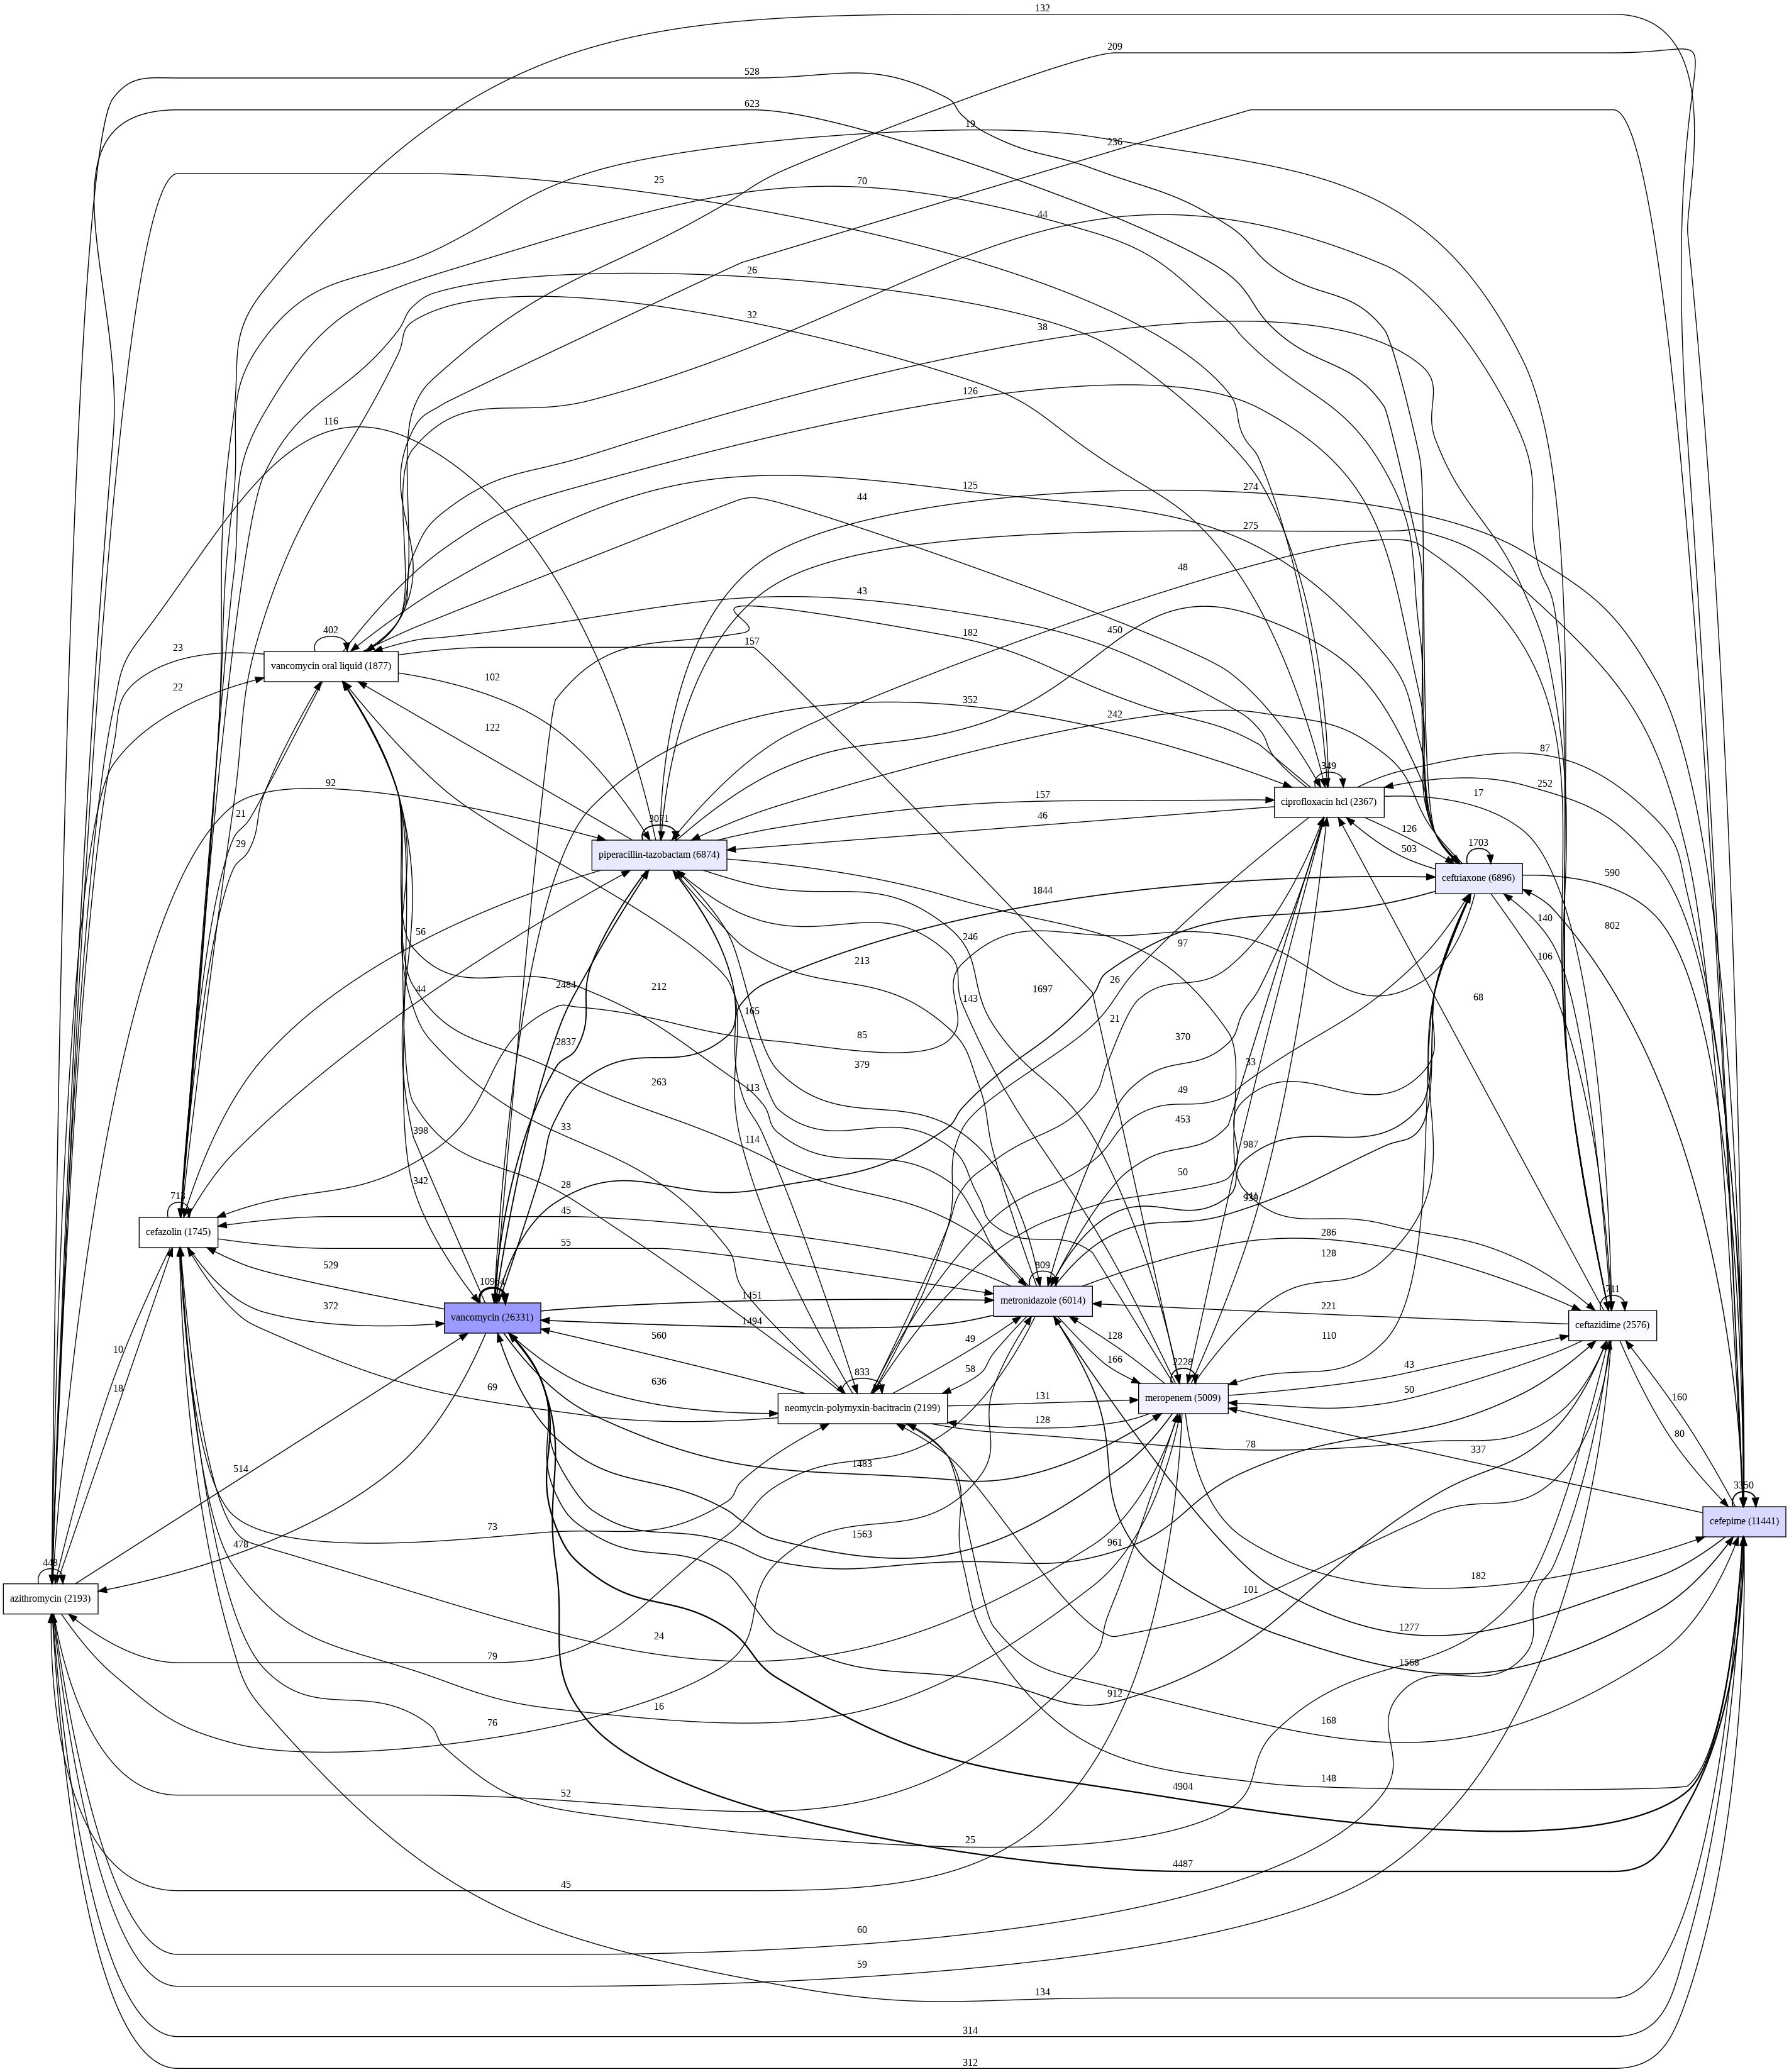

사망 환자 DFG 생성 중...


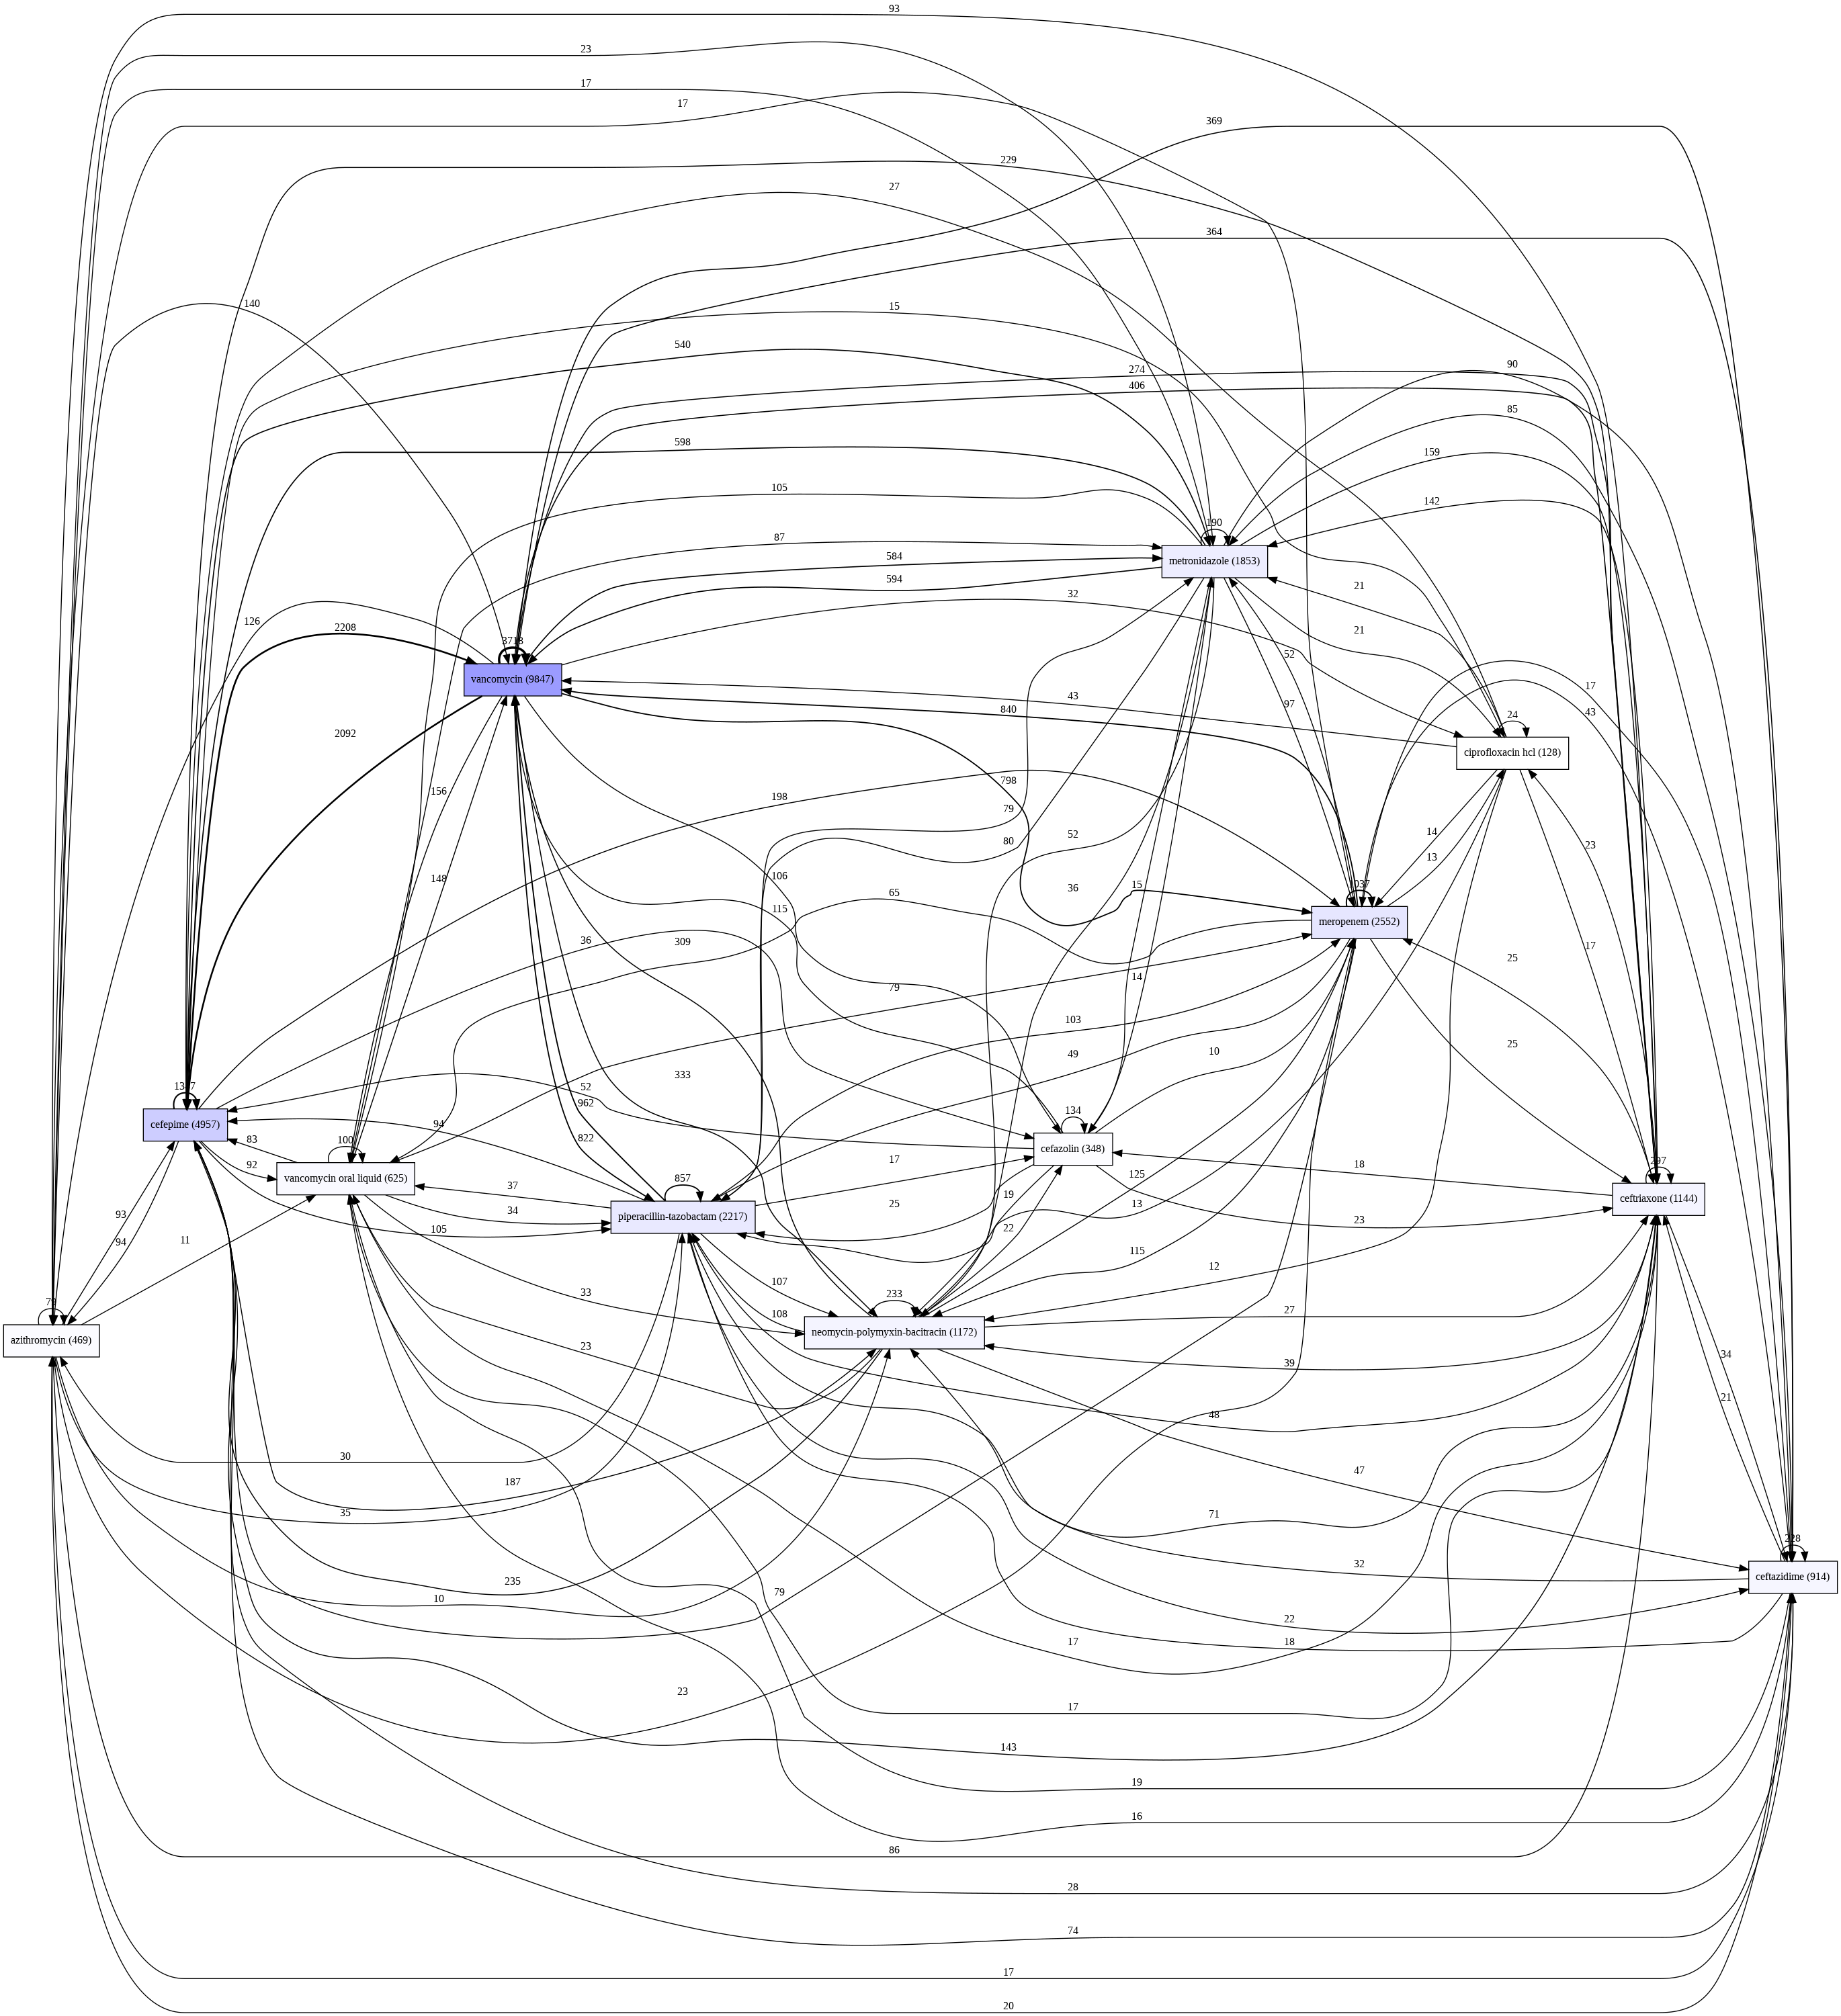

In [26]:
# ── 방법 1) Top-N
N = 12
top_acts = event_log['activity'].value_counts().head(N).index
elog_top = event_log[event_log['activity'].isin(top_acts)].copy() # elog -> event_log

dfg_top = discover_dfg(elog_top, variant='frequency')
MIN_EDGE_FREQ = 10  # 필요 시 조절 (데이터가 작으면 1로 줄여야 보임)
dfg_top = {k:v for k,v in dfg_top.items() if v >= MIN_EDGE_FREQ}

print("전체 Top-N DFG 생성 중...")
show_dfg(dfg_top, variant='frequency', save_path="dfg_topN_freq.svg")
#


# ── 방법 3) 사망/생존 분리 (Top-N 공통 기준 유지)
elog_alive = elog_top[elog_top['death'] == 0].copy()
elog_dead  = elog_top[elog_top['death'] == 1].copy()

dfg_alive = discover_dfg(elog_alive, variant='frequency')
dfg_dead  = discover_dfg(elog_dead,  variant='frequency')

dfg_alive = {k:v for k,v in dfg_alive.items() if v >= MIN_EDGE_FREQ}
dfg_dead  = {k:v for k,v in dfg_dead.items()  if v >= MIN_EDGE_FREQ}

print("생존 환자 DFG 생성 중...")
show_dfg(dfg_alive, variant='frequency', save_path="dfg_alive_topN_freq.svg")
#

print("사망 환자 DFG 생성 중...")
show_dfg(dfg_dead,  variant='frequency', save_path="dfg_dead_topN_freq.svg")